In [197]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import date
import datetime
from scipy.optimize import minimize, Bounds

In [198]:
balance_frame = 'MS'  # 1 month
Money = 1000
lamb = 0.2 
alpha = 2000
interval = "1d"

symbols  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
             'REM', "VNQ", "RWX", # re
             'TIP', "IEF", "TLT", "BWX", #fi
             'DBC', "GLD", #como
             'TWTR', 'INTC', 'TSM',"VWUSX", "AMC"]

# ----------- DATES ------
start_train_date = '2020-01-01'
end_train_date = '2021-01-01'
start_test_date = end_train_date
end_test_date = date.today()

balancing_dates = pd.date_range(start_test_date, end_test_date, 
                                freq = balance_frame).strftime("%Y-%m-%d").tolist()


today_price = get_data(symbols, date.today() - datetime.timedelta(days = 2),
                       date.today(), interval).tail(1)



In [199]:
def portfolio_compute(symbols, lamb, alpha, Money,
                      start_date, end_date, time_interval):
    
    # Pour le portfolio on a besoin de 1 mois de data sur lequelle 
    # on veut faire tourner le portefeuille ou bien il faut prendre plus de mois 
    # pour avoir une meilleur estimation
    
    all_stocks = get_data(symbols, start_date, end_date, time_interval)
    
    ret = (all_stocks/all_stocks.shift(1)).fillna(0)
    ret = ret.iloc[1: , :]
    
    log_ret = np.log(all_stocks/all_stocks.shift(1)).fillna(0)
    log_ret = log_ret.iloc[1: , :]
    
    cons = ({"type":"eq", "fun": lambda x: all_stocks[-1::].values[0]@np.array(x).T - Money}, 
            {"type": "ineq", "fun": lambda x: -np.sum(log_ret.mean()*x)+1}) 
 
    bounds = Bounds(0, Money)
    
    
    p = minimize(objective_corr, p0, 
                 method = "SLSQP", 
                 bounds=bounds,
                 args=(log_ret,lamb,alpha),
                 constraints= cons)
    Pos.append(p.x)
    
    return p.x

In [200]:
def get_data(symbo, start_date, end_date, time_interval):
    data = pd.DataFrame()
    for symbol in symbo:
        tmp_close = yf.download(symbol, 
                          start = start_date, 
                          end = end_date,
                          interval = time_interval,
                          threads = True,
                          progress = False)['Adj Close']
        data = pd.concat([data, tmp_close], axis=1)

    data.columns = symbo
    return data

def objective_corr(pos,log_ret,lamb,alpha):
    pos = np.array(pos)
    s = pos@np.corrcoef(log_ret.iloc[1: , :].fillna(0).T)@pos + lamb*TC(Pos,pos) - alpha*log_ret.mean()@pos
    return s

def TC(Pos,pos):
    if len(Pos)>1:
        return np.sum(np.abs(np.array(pos)-np.array(Pos[-1])))
    else: 
        return np.sum(np.abs(np.array(pos)))

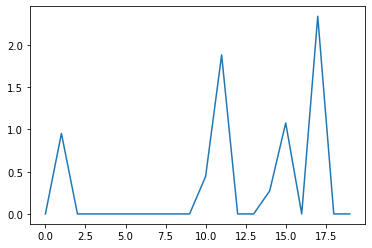

In [201]:
plt.plot(portfolio_compute(symbols, lamb, alpha, Money,
                        start_date = start_train_date, 
                        end_date = end_train_date, 
                        time_interval = interval).round(3))

In [202]:
from tqdm.notebook import tqdm_notebook
def backtesting(lamb, alpha):
    R = [] # argent gagné chaque mois en moyenne
    Pos_money = [] # Quantité d'argent placé par action chaque mois
    
    Pos = []
    p0 = [Money/(today_price.shape[1]*today_price[-1::].values[0][i]) for i in range(today_price.shape[1])]
    Pos.append(np.array(p0))

    for i in tqdm_notebook(range(len(balancing_dates)-1)):
        if i < 2:
            s_date = balancing_dates[i]
        else : 
            s_date = balancing_dates[i-2]

        portfolio_compute(symbols, lamb, alpha, Money,
                          start_date = s_date, 
                          end_date = balancing_dates[i], 
                          time_interval = interval)

        # Data for back testing  
        data_interval = get_data(symbols, balancing_dates[i], balancing_dates[i+1], interval)

        month_ret = (data_interval/data_interval.shift(1)).fillna(0).iloc[1: , :] #month return

        monthly_earning = month_ret.mean()@Pos[-1]

        Pos_money.append(data_interval.tail(1)*Pos[-1])
        R.append(monthly_earning)
        
    return Pos, R, Pos_money
    

In [203]:
backtesting(lamb, alpha)

  0%|          | 0/14 [00:00<?, ?it/s]

/Users/armand_morin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/armand_morin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/armand_morin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/armand_morin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/armand_morin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- QQQ: No data found for this date range, symbol may be delisted

1 Failed download:
- VGK: No data found for this date range, symbol may be delisted

1 Failed download:
- SCZ: No data found for this date range, symbol may be delisted

1 Failed download:
- EWJ: No data found for this date range, symbol may be delisted

1 Failed download:
- EEM: No data found for this date range, symbol may be delisted

1 Failed download:
- REM: No data found for this date range, symbol may be delisted

1 Failed download:
- VNQ: No data found for this date range, symbol may be delisted

1 Failed download:
- RWX: No data found for this date range, symbol may be delisted

1 Failed download:
- TIP: No data found for this date range, symbol may be delisted

1 Failed download:
- IEF: No data found for this date range, symbol may be delisted

1 Failed download:
- TLT: No data found for this date range, sym

IndexError: index 0 is out of bounds for axis 0 with size 0

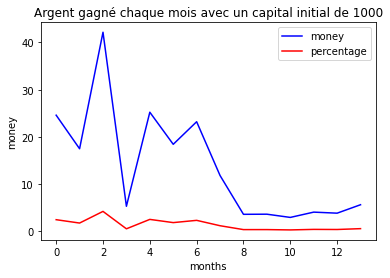

In [184]:
plt.plot(R,color = 'blue', label = 'money')
plt.plot([x/10 for x in R], color = 'red',label = 'percentage')
plt.xlabel('months')
plt.ylabel('money')
plt.legend()
plt.title('Argent gagné chaque mois avec un capital initial de ' + str(Money))
plt.show()

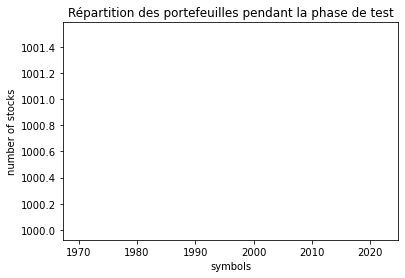

In [185]:
for x in Pos_money:
    plt.plot(x.round(3))
    
plt.plot(np.array(Pos_money).mean(axis = 0),color = 'green')
plt.xlabel('symbols')
plt.ylabel('number of stocks')
plt.title('Répartition des portefeuilles pendant la phase de test')
plt.show()

In [ ]:
Pos_money

In [204]:
Calib_a = []
A = [200,500,700,1000,1200,1500,1700,2000,2200,2500,2700,3000,3200,3500,3700,4000,4500,5000,5500]

for a in A:
    lamb = 0.2
    alpha = a 
    
    for i in tqdm_notebook(range(len(balancing_dates)-1)):
        if i < 2:
            s_date = balancing_dates[i]
        else : 
            s_date = balancing_dates[i-2]

        portfolio_compute(symbols, lamb, a, Money,
                          start_date = s_date, 
                          end_date = balancing_dates[i], 
                          time_interval = interval)
  
        data_interval = get_data(symbols, balancing_dates[i], balancing_dates[i+1], interval)

        month_ret = (data_interval/data_interval.shift(1)).fillna(0).iloc[1: , :]

        monthly_earning = month_ret.mean()@Pos[-1]
        Calib_a.append(monthly_earning)
    
plt.append(Calib_a)

  0%|          | 0/14 [00:00<?, ?it/s]


1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- QQQ: No data found for this date range, symbol may be delisted

1 Failed download:
- VGK: No data found for this date range, symbol may be delisted

1 Failed download:
- SCZ: No data found for this date range, symbol may be delisted

1 Failed download:
- EWJ: No data found for this date range, symbol may be delisted

1 Failed download:
- EEM: No data found for this date range, symbol may be delisted

1 Failed download:
- REM: No data found for this date range, symbol may be delisted

1 Failed download:
- VNQ: No data found for this date range, symbol may be delisted

1 Failed download:
- RWX: No data found for this date range, symbol may be delisted

1 Failed download:
- TIP: No data found for this date range, symbol may be delisted

1 Failed download:
- IEF: No data found for this date range, symbol may be delisted

1 Failed download:
- TLT: No data found for this date range, sym

IndexError: index 0 is out of bounds for axis 0 with size 0